<a href="https://colab.research.google.com/github/HeerRawal0138pg/Medium-assignment-heer01/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving wine_Dataset.csv to wine_Dataset (3).csv
Available columns in dataset: Index(['Type', 'Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Magnesium', 'Phenols',
       'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Color', 'Hue',
       'Dilution', 'Proline'],
      dtype='object')
ANOVA Result: F_onewayResult(statistic=135.07762424279912, pvalue=3.319503795619655e-36)
T-Test Result: TtestResult(statistic=0.19243693299331574, pvalue=0.8476218290439016, df=176.0)
Chi-Square Test Result: 41.1929060237129 p-value: 1.1352045160914385e-09


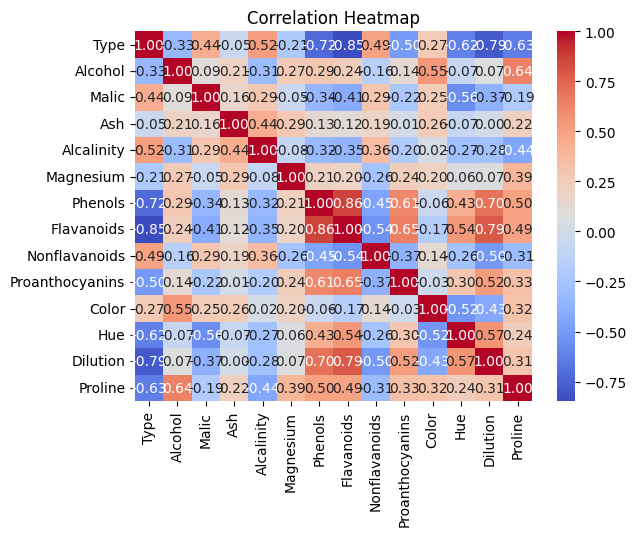

Simple Linear Regression Coefficients: [-0.02020058]


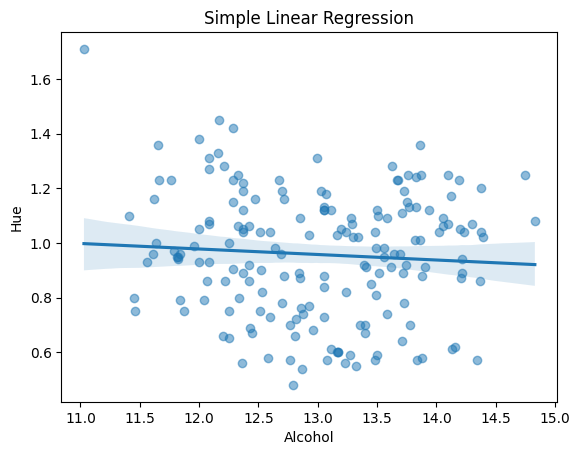

Multiple Linear Regression Coefficients: [-0.00658935 -0.11514965  0.01883603]
Logistic Regression Coefficients: [[ 1.92922529 -0.45559193  0.61842896]
 [-2.10407698 -0.27570678 -1.10408723]
 [ 0.17485169  0.73129872  0.48565827]]
Skipping MANOVA: Not enough independent variables after removing collinearity.


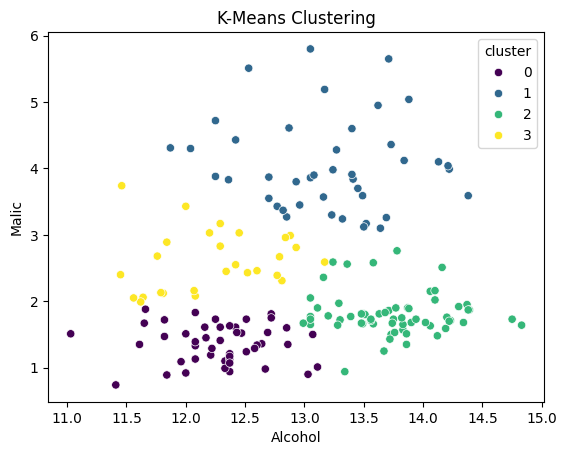

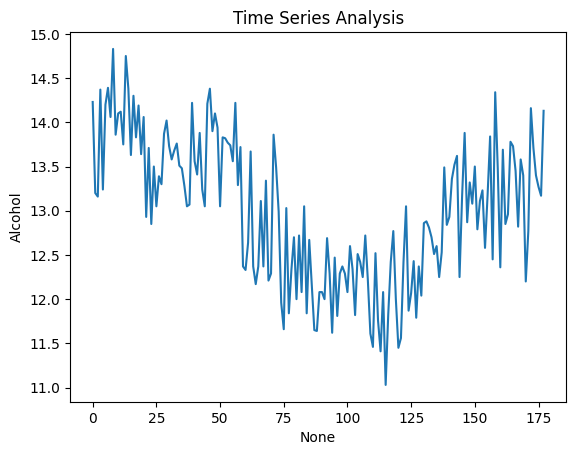

PCA Explained Variance Ratio: [0.63707131 0.32767804]


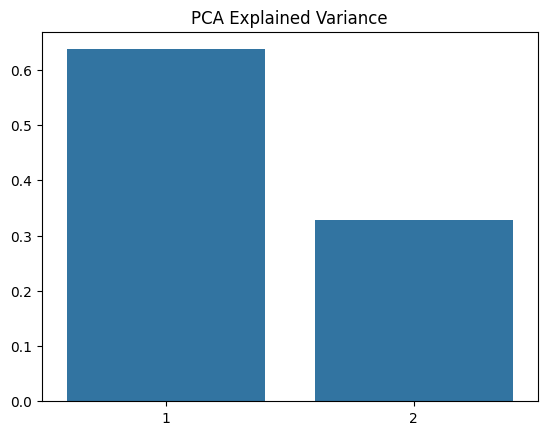

<lifelines.CoxPHFitter: fitted with 178 total observations, 0 right-censored observations>
             duration col = 'Proline'
      baseline estimation = breslow
   number of observations = 178
number of events observed = 178
   partial log-likelihood = -692.74
         time fit was run = 2025-02-16 11:43:18 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Alcohol   -1.11      0.33      0.12           -1.34           -0.87                0.26                0.42
Malic      0.30      1.35      0.07            0.15            0.44                1.16                1.56
Ash       -0.50      0.61      0.30           -1.08            0.08                0.34                1.08

           cmp to     z      p  -log2(p)
covariate                               
Alcohol      0.00 -9.28 <0.005     65.68
Malic        0.00  4.01 <0.005     14.04
Ash          0.00 -1.70   0.09      3.48
---
Concordance = 0.74
Partial AIC = 1391.48
log-likelihood ratio test = 110.25 on 3 df
-log2(p) of ll-ratio test = 76.45

In [7]:
!pip install lifelines
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from statsmodels.multivariate.manova import MANOVA
from lifelines import CoxPHFitter
from google.colab import files
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Install necessary package

# Upload file
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Get the uploaded file name

# Load dataset
df = pd.read_csv(file_name)

# Display available columns
print("Available columns in dataset:", df.columns)

# Data Cleaning: Convert categorical to numerical where needed
df = df.apply(pd.to_numeric, errors='coerce')

# Filter only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

# Define actual column names from the dataset
categorical_column = 'Type'  # Change this to the actual categorical column
numerical_column = 'Alcohol'  # Change this to an actual numeric column
binary_column = 'Malic'  # Change this to a valid binary column

df.dropna(inplace=True)  # Drop missing values for better accuracy

# ANOVA: Testing variance between multiple groups
anova_result = stats.f_oneway(*[df[df[categorical_column] == category][numerical_column].dropna()
                                for category in df[categorical_column].unique() if pd.notna(category)])
print("ANOVA Result:", anova_result)

# t-Test: Comparing two groups
ttest_result = stats.ttest_ind(df[df[binary_column] > df[binary_column].median()][numerical_column].dropna(),
                               df[df[binary_column] <= df[binary_column].median()][numerical_column].dropna())
print("T-Test Result:", ttest_result)

# Chi-Square Test: Relationship between two categorical variables
contingency_table = pd.crosstab(df[categorical_column], df[binary_column] > df[binary_column].median())
chi2, p, _, _ = stats.chi2_contingency(contingency_table)
print("Chi-Square Test Result:", chi2, "p-value:", p)

# Correlation Analysis with Heatmap
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# Simple Linear Regression with Scatter Plot
X = df[[numerical_column]]
y = df['Hue']  # Change this to another dependent numeric variable
lin_reg = LinearRegression().fit(X, y)
print("Simple Linear Regression Coefficients:", lin_reg.coef_)
sns.regplot(x=numerical_column, y='Hue', data=df, scatter_kws={"alpha":0.5})
plt.title("Simple Linear Regression")
plt.show()

# Multiple Linear Regression
X_multi = df[['Alcohol', 'Malic', 'Ash']]  # Change to valid numeric columns
y_multi = df['Hue']
mlr = LinearRegression().fit(X_multi, y_multi)
print("Multiple Linear Regression Coefficients:", mlr.coef_)

# Logistic Regression
if df[categorical_column].nunique() > 1:
    log_reg = LogisticRegression().fit(X_multi, df[categorical_column])
    print("Logistic Regression Coefficients:", log_reg.coef_)
else:
    print("Skipping Logistic Regression: Not enough class variation.")

# MANOVA: Handling collinearity using Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_multi.columns
vif_data["VIF"] = [variance_inflation_factor(X_multi.values, i) for i in range(len(X_multi.columns))]

# Remove variables with high VIF (e.g., VIF > 5)
high_vif_vars = vif_data[vif_data["VIF"] > 5]["Variable"].tolist()
reduced_vars = list(set(X_multi.columns) - set(high_vif_vars))

if len(reduced_vars) >= 2:
    try:
        manova = MANOVA.from_formula(f"{' + '.join(reduced_vars)} ~ {categorical_column}", data=df)
        print("MANOVA Result:\n", manova.mv_test())
    except np.linalg.LinAlgError:
        print("Skipping MANOVA: Singular matrix due to collinearity.")
else:
    print("Skipping MANOVA: Not enough independent variables after removing collinearity.")

# Cluster Analysis (4 clusters using K-Means) with Cluster Visualization
kmeans = KMeans(n_clusters=4, random_state=42).fit(X_multi)
df['cluster'] = kmeans.labels_
sns.scatterplot(x=df['Alcohol'], y=df['Malic'], hue=df['cluster'], palette='viridis')
plt.title("K-Means Clustering")
plt.show()

# Time Series Analysis
sns.lineplot(data=df, x=df.index, y=numerical_column)
plt.title("Time Series Analysis")
plt.show()

# PCA: Reducing dimensions with Explained Variance Plot
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_multi)
print("PCA Explained Variance Ratio:", pca.explained_variance_ratio_)
sns.barplot(x=[1,2], y=pca.explained_variance_ratio_)
plt.title("PCA Explained Variance")
plt.show()

# Conjoint Analysis: Placeholder

# Cox Proportional Hazards Model (Assuming time-to-event data)
cph = CoxPHFitter()
cph.fit(df[['Proline', 'Alcohol', 'Malic', 'Ash']], duration_col='Proline')
cph.print_summary()